# Fairness in Nodule Detection

Description: This notebook examines the profile of the SUMMIT sample (both in total and available) focusing on protected groups Age, Gender and Ethnicity. Informed by the composition of the sample, experiments are designed in order to show any bias when used to train a nodule detection algorithm.

In [3]:
# libraries
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import re
import seaborn as sns

workspace_path = Path(os.getcwd()).parent
REGENERATE = False

# Set up scan metadata and nodule metadata

In [4]:
import json

recode = {
       'radiology_report_nodule_brock_score' : 'nodule_brock_score',
       'radiology_report_nodule_category' : 'nodule_category',
       'radiology_report_nodule_diameter_mm' : 'nodule_diameter_mm',
       'radiology_report_nodule_lesion_id' : 'nodule_lesion_id',
       'radiology_report_nodule_lung_rads' : 'nodule_lung_rads',
       'radiology_report_nodule_mass' : 'nodule_mass',
       'radiology_report_nodule_mass_core' : 'nodule_mass_core',
       'radiology_report_nodule_mass_double_time_core' : 'nodule_mass_double_time_core',
       'radiology_report_nodule_mass_doubling_time' : 'nodule_mass_doubling_time',
       'radiology_report_nodule_reliable_segment' : 'nodule_reliable_segment',
       'radiology_report_nodule_site' : 'nodule_site',
       'radiology_report_nodule_size_volume_cub_mm' : 'nodule_size_volume_cub_mm',
       'radiology_report_nodule_slice_number' : 'nodule_slice_number',
       'radiology_report_nodule_spiculation' : 'nodule_spiculation',
       'radiology_report_nodule_subsolid_major_axis_diameter' : 'nodule_subsolid_major_axis_diameter',
       'radiology_report_nodule_type' : 'nodule_type',
       'radiology_report_nodule_volume_core' : 'nodule_volume_core',
       'radiology_report_nodule_volume_doubling_time' : 'nodule_volume_doubling_time',
       'radiology_report_nodule_volume_percentage_change' : 'nodule_volume_percentage_change',
       'radiology_report_nodule_volume_volume_double_time_core' : 'nodule_volume_volume_double_time_core',
       'radiology_report_nodule_x_coordinate': 'nodule_x_coordinate',
       'radiology_report_nodule_y_coordinate': 'nodule_y_coordinate',
       'radiology_report_nodule_z_coordinate' : 'nodule_z_coordinate',
       'radiology_report_management_plan' : 'management_plan',
       'participant_details_gender' : 'gender',
       'participant_age_at_consent_cats' : 'age_group',
       'lung_health_check_demographics_race_ethnicgroup' : 'ethnic_group'
}

exclusion_list = [
    'summit-9754-pkv',
    'summit-2625-nvf',
    'summit-8935-guu',
    'summit-4236-sar',
    'summit-3399-wdd',
    'summit-5628-vrn',
    'summit-6597-erv',
    'summit-4236-sar',
    'summit-6344-jbm',
    'summit-6242-zvz',
    'summit-5789-jmc',
    'summit-5659-dgq',
    'summit-9754-pkv', 
    'summit-2625-nvf',
    'summit-8935-guu',
    'summit-6242-zvz',
    'summit-3636-cbv', 
    'summit-6585-puj'
    ]

person_data = (
    pd.read_csv(f'{workspace_path}/data/summit/data/person_data.csv', low_memory=False)
    .drop('Unnamed: 0', axis=1)
    .assign(scan_id=lambda x: x.LDCT_RADIOLOGY_REPORT_main_participant_id + '_Y0_BASELINE_A')
    .assign(Available=lambda x: x.ScansTransfer_state == 'LUNG50=VEOLITY')
)

person_data = person_data[~person_data.LDCT_RADIOLOGY_REPORT_main_participant_id.isin(exclusion_list)]

nodule_data = (
    pd.read_csv(f'{workspace_path}/data/summit/data/nodule_data.csv', low_memory=False)
    .assign(scan_id=lambda x: x.participant_id + '_Y0_BASELINE_A')
    .rename(columns=recode)
    .drop('Unnamed: 0', axis=1)
)

solid_reliable = (nodule_data.nodule_size_volume_cub_mm < 40)&(nodule_data.nodule_type=='SOLID')&~(nodule_data.nodule_reliable_segment.str.lower().str.startswith('u'))
solid_unreliable = (nodule_data.nodule_diameter_mm < 4)&(nodule_data.nodule_type=='SOLID')&(nodule_data.nodule_reliable_segment.str.lower().str.startswith('u'))
non_solid_small = (nodule_data.nodule_diameter_mm < 4)&(nodule_data.nodule_type=='NON_SOLID')

nodule_data = nodule_data[~(solid_reliable|solid_unreliable|non_solid_small)]
nodule_data = nodule_data[~nodule_data.participant_id.isin(exclusion_list)]
nodule_data = nodule_data[nodule_data.nodule_type!='ENDOBRONCHIAL']


# Common functions

In [22]:
import subprocess
import pandas as pd
from seaborn import heatmap


#utility functions
def crosstab_with_percentages(rows, columns, x_order=None, y_order=None, table=False, heatmap=False):
    # Create the crosstab with absolutes
    cols = [c.astype(str) for c in columns]
    rows = [r.astype(str) for r in rows]

    xabs = pd.crosstab(rows, cols).fillna(0)
    xperc = pd.crosstab(rows, cols, normalize='columns').fillna(0)

    if x_order:
        xabs = xabs.reindex(x_order, axis=1)
        xperc = xperc.reindex(x_order, axis=1)

    if y_order:
        xabs = xabs.reindex(y_order)
        xperc = xperc.reindex(y_order)

    combined_data = {}

    for (adx, rabs), (pdx, rperc) in zip(xabs.iterrows(), xperc.iterrows()):

        row_data = {}
        row_total = 0

        for col in xabs.columns:
            row_data[col] = f"{rabs[col]} ({rperc[col]:.1%})"
            row_total += rabs[col]

        row_data['Total'] = f'{row_total} ({row_total / xabs.sum().sum():.1%})'
        combined_data[adx] = row_data

    row_data = {}
    row_total = 0
    for col in xabs.columns:
        row_data[col] = f'{sum(xabs[col])}'
        row_total += xabs[col].sum()

    row_data['Total'] = row_total
    combined_data['Total'] = row_data

    if table:
        display(pd.DataFrame.from_dict(combined_data).T)
        
    
    if heatmap:
        sns.heatmap(xperc, annot=True, fmt=".1%", cmap='Blues')
        plt.show()

    return xperc, pd.DataFrame.from_dict(combined_data)

# Profile the data
def profile_sample(df, column='Available', table=False, heatmap=False):
    _, xgender = crosstab_with_percentages(
        [df.participant_details_gender],
        [df[column]],
        table=table,
        heatmap=heatmap
    )

    _, xage = crosstab_with_percentages(
        [df.participant_age_at_consent_cats],
        [df[column]],
        table=table,
        heatmap=heatmap
    )
    
    _, xethnic = crosstab_with_percentages(
        [df.lung_health_check_demographics_race_ethnicgroup],
        [df[column]],
        table=table,
        heatmap=heatmap
    )

    return pd.concat([xgender.drop('Total', axis=1), xage.drop('Total', axis=1), xethnic], axis=1).T

def show_heatmap_of_differences(df):
    
    df.fillna('0 (0%)', inplace=True)
    df.drop('Total', axis=0, inplace=True)
    heatmap_data = {}

    for idx, row in df.iterrows():
        total = float(re.search(r"\((.*?)%\)", row['Total']).group(1))

        heatmap_row = {}
        for col in row.index:
            if col != 'Total':
                val = float(re.search(r"\((.*?)%\)", row[col]).group(1))
                diff = val - total

                heatmap_row[col] = diff
        
        heatmap_data[idx] = heatmap_row

    sns.heatmap(
        pd.DataFrame.from_dict(heatmap_data).T, 
        center=0, vmin=-50, vmax=50,
        annot=True, cmap='RdBu')
    plt.show()

def combine_datasets_profiles(key, dataset_dict, heatmap=True):
    has_training = dataset_dict['training'][key].shape[0] > 0
    has_validation = dataset_dict['validation'][key].shape[0] > 0
    has_test = dataset_dict['test'][key].shape[0] > 0
    has_holdout = dataset_dict['holdout'][key].shape[0] > 0

    print(has_training, has_validation, has_test, has_holdout)
    if has_training:
        xuseable_trn = (
            profile_sample(dataset_dict['training'][key], 
            table=False, 
            heatmap=False)
            .drop('True', axis=1)
            .rename(columns={'Total':'Training'})
        )

    if has_validation:    
        xuseable_val = (
            profile_sample(dataset_dict['validation'][key],
            table=False,
            heatmap=False)
            .drop('True', axis=1)
            .rename(columns={'Total':'Validation'})
        )

    if has_test:
        xuseable_tst = (
            profile_sample(dataset_dict['test'][key], 
            table=False, 
            heatmap=False)
            .drop('True', axis=1)
            .rename(columns={'Total':'Test'})
        )

    if has_holdout:
        xuseable_hld = (
            profile_sample(dataset_dict['holdout'][key], 
            table=False, 
            heatmap=False)
            .drop('True', axis=1)
            .rename(columns={'Total':'Holdout'})
        )

    xall  = (
        profile_sample(dataset_dict['total'], 
        table=False, 
        heatmap=False)
        .drop('True', axis=1)
    )

    if has_training and has_validation and has_test and has_holdout:

        xcombined = (
            pd.merge(xuseable_trn, xuseable_val, how='left', left_index=True, right_index=True)
            .merge(xuseable_tst, how='left', left_index=True, right_index=True)
            .merge(xuseable_hld, how='left', left_index=True, right_index=True)
            .merge(pd.DataFrame(xall, columns=['Total']), how='left', left_index=True, right_index=True)
        )

    elif has_training and has_validation and has_test:

        xcombined = (
            pd.merge(xuseable_trn, xuseable_val, how='left', left_index=True, right_index=True)
            .merge(xuseable_tst, how='left', left_index=True, right_index=True)
            .merge(pd.DataFrame(xall, columns=['Total']), how='left', left_index=True, right_index=True)
        )

    elif has_training and has_validation:
        
        xcombined = (
            pd.merge(xuseable_trn, xuseable_val, how='left', left_index=True, right_index=True)
            .merge(pd.DataFrame(xall, columns=['Total']), how='left', left_index=True, right_index=True)
        )
    elif has_test:

        xcombined = (
            xuseable_tst
            .merge(pd.DataFrame(xall, columns=['Total']), how='left', left_index=True, right_index=True)
        )
    


    display(xcombined)
    if heatmap:
        show_heatmap_of_differences(xcombined)

def save_metadata(dataset_dict, key, nodule_data, exclude_nodule_data=None):

    metadata_path = Path(f'{workspace_path}/metadata/summit/{key}')
    Path(metadata_path).mkdir(exist_ok=True, parents=True)

    datasplit_path = Path(f'{workspace_path}/models/detection/datasplits/summit/{key}')
    Path(datasplit_path).mkdir(exist_ok=True, parents=True)

    dataset_json = {'training' : [], 'validation' : [], 'test' : [], 'holdout' : []}

    for dataset in ['training', 'validation', 'test', 'holdout']:
        dataset_dict[dataset][key].to_csv(f'{metadata_path}/{dataset}_scans_metadata.csv', index=False)
        dataset_dict[dataset][key]['scan_id'].to_csv(f'{metadata_path}/{dataset}_scans.csv', index=False)

        print(f'{key} {dataset} scans metadata saved')
        print(f'{key} {dataset} scans #: {dataset_dict[dataset][key].shape[0]}')

        metadata = nodule_data[nodule_data.scan_id.isin(dataset_dict[dataset][key].scan_id)]
        metadata.to_csv(f'{metadata_path}/{dataset}_metadata.csv', index=False)

        print(f'{key} {dataset} metadata saved')
        print(f"{key} {dataset} nodules: {metadata.shape[0]} (Actionable: {metadata[metadata.management_plan.isin(['3_MONTH_FOLLOW_UP_SCAN','URGENT_REFERRAL', 'ALWAYS_SCAN_AT_YEAR_1'])].shape[0]})")


        if exclude_nodule_data is not None:
            exclude_metadata = exclude_nodule_data[exclude_nodule_data.scan_id.isin(dataset_dict[dataset][key].scan_id)]
            exclude_metadata.to_csv(f'{metadata_path}/{dataset}_exclude_metadata.csv', index=False)

            print(f'{key} {dataset} exclude metadata saved')
            print(f"{key} {dataset} excluded nodules: {exclude_metadata.shape[0]}")


        for scan_id in dataset_dict[dataset][key].scan_id:
            study_id = scan_id.split('_')[0]
            scan_dict = {'box' : [], 'image' : f"{study_id}/{scan_id}.nii.gz", 'label' : []}

            for idx, row in metadata[metadata.scan_id == scan_id].iterrows():
                scan_dict['box'].append([
                    row.nodule_x_coordinate,
                    row.nodule_y_coordinate,
                    row.nodule_z_coordinate,
                    row.nodule_diameter_mm,
                    row.nodule_diameter_mm,
                    row.nodule_diameter_mm
                ])
                scan_dict['label'].append(0)

            if (dataset in ['training','validation'] and len(scan_dict['box']) > 0) or (dataset in ['test','holdout']):
                dataset_json[dataset].append(scan_dict)

    print(f'dataset json nodules saved for {key}')
    print(f'Training: {len(dataset_json["training"])}')
    print(f'Validation: {len(dataset_json["validation"])}')
    print(f'Test: {len(dataset_json["test"])}')
    print(f'Holdout: {len(dataset_json["holdout"])}')

    with open(f'{datasplit_path}/dataset_{key}.json', 'w') as f:
        json.dump(dataset_json, f)

def deploy_to_cluster(dataset_name, use_poxy=True):

    if use_poxy:
        host = 'localhost'
    else:
        host = 'little'

    deploy_metadata_cmd = [
            "scp",
            "-r",
            f"{workspace_path}/metadata/summit/{dataset_name}",
            f"jmccabe@{host}:/home/jmccabe/jobs/SOTAEvaluationNoduleDetection/metadata/summit"
        ]

    if use_poxy:
        deploy_metadata_cmd.insert(1, "-P")
        deploy_metadata_cmd.insert(2, "2222")

    # Deploy to cluster
    subprocess.run(deploy_metadata_cmd)

    deploy_datasplit_cmd = [
            "scp",
            "-r",
            f"{workspace_path}/models/detection/datasplits/summit/{dataset_name}",
            f"jmccabe@{host}:/home/jmccabe/jobs/SOTAEvaluationNoduleDetection/models/detection/datasplits/summit"
        ]

    if use_poxy:
        deploy_datasplit_cmd.insert(1, "-P")
        deploy_datasplit_cmd.insert(2, "2222")

    subprocess.run(deploy_datasplit_cmd)

    print(f'{dataset_name} deployed to cluster')

# All available SUMMIT data

,False,True,Total
FEMALE,3168 (45.2%),2336 (39.3%),5504 (42.5%)
MALE,3841 (54.8%),3603 (60.7%),7444 (57.5%)
55-59,1541 (22.0%),1220 (20.5%),2761 (21.3%)
60-64,1766 (25.2%),1473 (24.8%),3239 (25.0%)
65-69,1760 (25.1%),1530 (25.8%),3290 (25.4%)
70-75,1563 (22.3%),1397 (23.5%),2960 (22.9%)
75+,379 (5.4%),319 (5.4%),698 (5.4%)
Asian or Asian British,178 (2.5%),666 (11.2%),844 (6.5%)
Black,123 (1.8%),454 (7.6%),577 (4.5%)
Mixed,155 (2.2%),128 (2.2%),283 (2.2%)


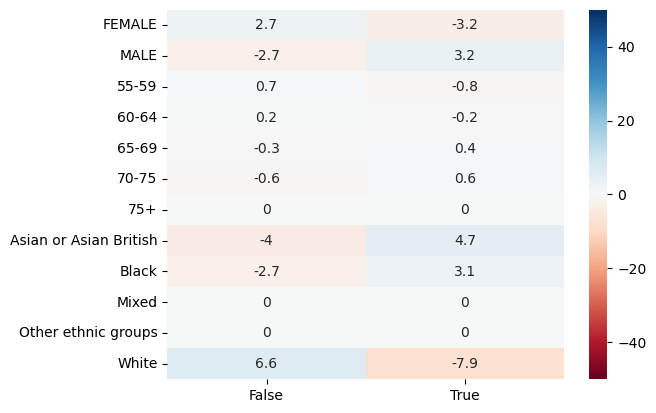

In [6]:
# Show protected characteristics by available sample
xcombined = profile_sample(person_data, table=False, heatmap=False)
display(xcombined)
show_heatmap_of_differences(xcombined)


In [7]:

# Check the protected groups by each other to see whether there is bias

available_data = person_data[person_data.Available]

xperc, xtab = crosstab_with_percentages(
    columns=[
        person_data.participant_age_at_consent_cats
    ],
    rows=[person_data.participant_details_gender],
    table=False,
    heatmap=False
)

display(xtab)

xperc, xtab = crosstab_with_percentages(
    columns=[person_data.lung_health_check_demographics_race_ethnicgroup],
    rows=[person_data.participant_details_gender],
    table=False,
    heatmap=False
)

display(xtab)

xperc, xtab = crosstab_with_percentages(
    columns=[person_data.participant_age_at_consent_cats],
    rows=[person_data.lung_health_check_demographics_race_ethnicgroup],
    table=False,
    heatmap=False
)

display(xtab)

,FEMALE,MALE,Total
55-59,1218 (44.1%),1543 (55.9%),2761
60-64,1349 (41.6%),1890 (58.4%),3239
65-69,1349 (41.0%),1941 (59.0%),3290
70-75,1274 (43.0%),1686 (57.0%),2960
75+,314 (45.0%),384 (55.0%),698
Total,5504 (42.5%),7444 (57.5%),12948


,FEMALE,MALE,Total
Asian or Asian British,72 (8.5%),772 (91.5%),844
Black,221 (38.3%),356 (61.7%),577
Mixed,132 (46.6%),151 (53.4%),283
Other ethnic groups,116 (25.8%),334 (74.2%),450
White,4963 (46.0%),5831 (54.0%),10794
Total,5504 (42.5%),7444 (57.5%),12948


,Asian or Asian British,Black,Mixed,Other ethnic groups,White,Total
55-59,180 (6.5%),163 (5.9%),86 (3.1%),118 (4.3%),2214 (80.2%),2761
60-64,238 (7.3%),150 (4.6%),90 (2.8%),146 (4.5%),2615 (80.7%),3239
65-69,243 (7.4%),152 (4.6%),74 (2.2%),96 (2.9%),2725 (82.8%),3290
70-75,137 (4.6%),89 (3.0%),29 (1.0%),79 (2.7%),2626 (88.7%),2960
75+,46 (6.6%),23 (3.3%),4 (0.6%),11 (1.6%),614 (88.0%),698
Total,844 (6.5%),577 (4.5%),283 (2.2%),450 (3.5%),10794 (83.4%),12948


True True True False


,Training,Validation,Test,Total
FEMALE,1865 (39.2%),110 (37.0%),361 (40.5%),5504 (42.5%)
MALE,2887 (60.8%),187 (63.0%),530 (59.5%),7444 (57.5%)
55-59,963 (20.3%),63 (21.2%),194 (21.8%),2761 (21.3%)
60-64,1174 (24.7%),98 (33.0%),202 (22.7%),3239 (25.0%)
65-69,1246 (26.2%),58 (19.5%),226 (25.4%),3290 (25.4%)
70-75,1109 (23.3%),61 (20.5%),227 (25.5%),2960 (22.9%)
75+,260 (5.5%),17 (5.7%),42 (4.7%),698 (5.4%)
Asian or Asian British,509 (10.7%),41 (13.8%),116 (13.0%),844 (6.5%)
Black,372 (7.8%),17 (5.7%),65 (7.3%),577 (4.5%)
Mixed,101 (2.1%),7 (2.4%),20 (2.2%),283 (2.2%)


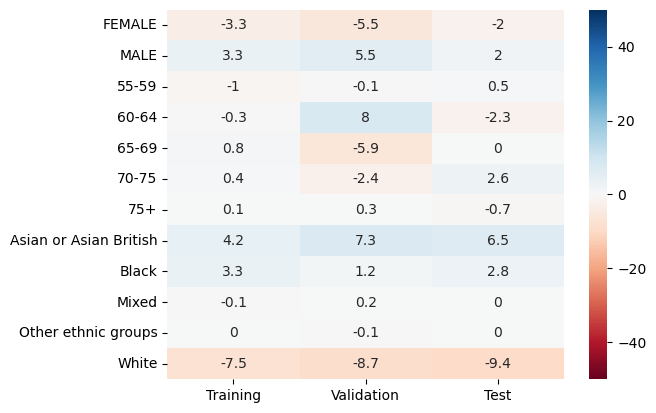

In [8]:

# Historically generated dataset no need to generate here

import test


training_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/partial/training_scans_metadata.csv', low_memory=False).assign(Available=True)
validation_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/partial/validation_scans_metadata.csv', low_memory=False).assign(Available=True)
test_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/partial/test_scans_metadata.csv', low_memory=False).assign(Available=True)
holdout_scans_metadata = test_scans_metadata.drop(test_scans_metadata.index)

datasets = {
    'total' : person_data,
    'training' : 
    {
        'partial' : training_scans_metadata
    },
    'validation' : 
    {
        'partial' : validation_scans_metadata
    },
    'test' : 
    {
        'partial' : test_scans_metadata
    },
    'holdout' : 
    {
        'partial' : holdout_scans_metadata
    }
}

combine_datasets_profiles('partial', datasets)

# Test-Balanced (Ethnicity, Skewed Gender)

When this sample was trained & evaluated on SUMMIT the numbers in the protected groups was so low that it was not possible to get a decent confidence interval to be confident of the results.

Therefore in order to reduce the confidence interval this next experiment will be to increase the Test cases for the protected groups whilst maintaining the best balance possible for the rest of the training.

The following work generates the Trn, Val & Tst datasets along those lines.

True True True False


,Training,Validation,Test,Total
FEMALE,1961 (38.6%),125 (46.8%),250 (42.1%),5504 (42.5%)
MALE,3118 (61.4%),142 (53.2%),344 (57.9%),7444 (57.5%)
55-59,1033 (20.3%),52 (19.5%),135 (22.7%),2761 (21.3%)
60-64,1267 (24.9%),59 (22.1%),148 (24.9%),3239 (25.0%)
65-69,1294 (25.5%),71 (26.6%),165 (27.8%),3290 (25.4%)
70-75,1213 (23.9%),70 (26.2%),114 (19.2%),2960 (22.9%)
75+,272 (5.4%),15 (5.6%),32 (5.4%),698 (5.4%)
Asian or Asian British,443 (8.7%),25 (9.4%),198 (33.3%),844 (6.5%)
Black,244 (4.8%),12 (4.5%),198 (33.3%),577 (4.5%)
Mixed,119 (2.3%),9 (3.4%),NaN,283 (2.2%)


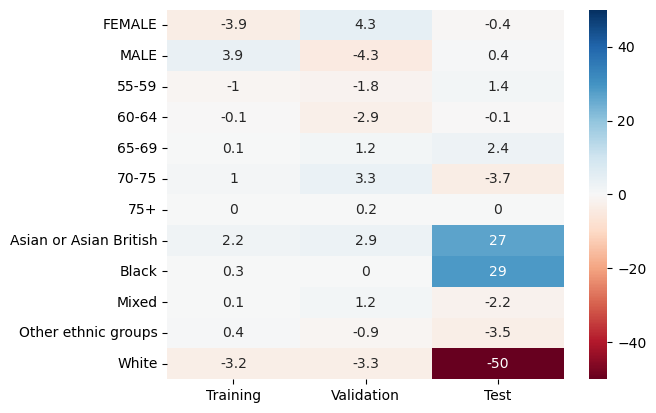

In [9]:


# Historically generated dataset no need to generate here

training_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/training_scans_metadata.csv', low_memory=False).assign(Available=True)
validation_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/validation_scans_metadata.csv', low_memory=False).assign(Available=True)
test_scans_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/test_scans_metadata.csv', low_memory=False).assign(Available=True)
holdout_scans_metadata = test_scans_metadata.drop(test_scans_metadata.index)

datasets = {
    'total' : person_data,
    'training' : 
    {
        'test_balanced' : training_scans_metadata
    },
    'validation' : 
    {
        'test_balanced' : validation_scans_metadata
    },
    'test' : 
    {
        'test_balanced' : test_scans_metadata
    },
    'holdout' : 
    {
        'test_balanced' : holdout_scans_metadata
    }
}

combine_datasets_profiles('test_balanced', datasets)

# Male only - Ethnicity

In [10]:
male_only = person_data[
    person_data['Available']&\
    (person_data['participant_details_gender'] == 'MALE')
]


display(male_only['lung_health_check_demographics_race_ethnicgroup'].value_counts())

male_white_ds = male_only[male_only['lung_health_check_demographics_race_ethnicgroup']=='White']
male_asian_ds = male_only[male_only['lung_health_check_demographics_race_ethnicgroup']=='Asian or Asian British']
male_black_ds = male_only[male_only['lung_health_check_demographics_race_ethnicgroup']=='Black']


# Fix the Test dataset as 140 for White, Black and Asian
tst_male_white_ds = male_white_ds.sample(140, random_state=42)
tst_male_asian_ds = male_asian_ds.sample(140, random_state=42)
tst_male_black_ds = male_black_ds.sample(140, random_state=42)

test_ds = pd.concat([
    tst_male_white_ds,
    tst_male_asian_ds,
    tst_male_black_ds
])

total = 5 * 3 * 140
tota_trn_val = 0.8 * total
training_and_validation = male_only.drop(test_ds.index)

proportions = {
    'White'                     :  tota_trn_val * 0.834,
    'Asian or Asian British'    :  tota_trn_val * 0.065,
    'Black'                     :  tota_trn_val * 0.045,
    'Mixed'                     :  tota_trn_val * 0.022,
    'Other ethnic groups'       :  tota_trn_val * 0.034
}

subset = []
for ethnic_group, cnt in proportions.items():
    subset.append(training_and_validation[training_and_validation['lung_health_check_demographics_race_ethnicgroup']==ethnic_group].sample(int(cnt), random_state=42))

training_and_validation = pd.concat(subset)
training_ds = training_and_validation.sample(frac=(15/16), random_state=42)
validation_ds = training_and_validation.drop(training_ds.index)

datasets['training']['male_only']       = training_ds
datasets['validation']['male_only']     = validation_ds
datasets['test']['male_only']           = test_ds
datasets['holdout']['male_only']        = test_ds.drop(test_ds.index)


White                     2494
Asian or Asian British     609
Black                      282
Other ethnic groups        149
Mixed                       69
Name: lung_health_check_demographics_race_ethnicgroup, dtype: int64

In [11]:

if REGENERATE:
    combine_datasets_profiles('male_only', datasets)
    _ = save_metadata(datasets, 'male_only', nodule_data)

    deploy_to_cluster('male_only', use_poxy=False)


## Create Test Dataset of the Female Only Group - Inference Only

This is a test dataset to test performance on the different subsets of Female when trained on Male only

1. Create one small one with balanced test data
2. Create one with everything


False False True False


,Test,Total
FEMALE,171 (100.0%),5504 (42.5%)
55-59,55 (32.2%),2761 (21.3%)
60-64,39 (22.8%),3239 (25.0%)
65-69,37 (21.6%),3290 (25.4%)
70-75,34 (19.9%),2960 (22.9%)
75+,6 (3.5%),698 (5.4%)
Asian or Asian British,57 (33.3%),844 (6.5%)
Black,57 (33.3%),577 (4.5%)
White,57 (33.3%),10794 (83.4%)
Total,171,12948


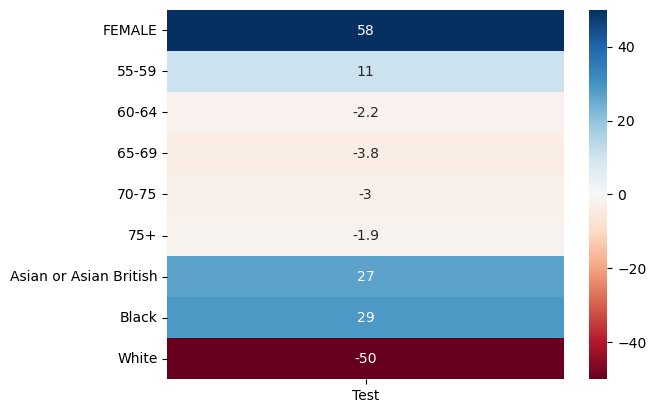

In [12]:
# Balanced the Test Dataset
female_only = person_data[
    person_data['Available']&\
    (person_data['participant_details_gender'] == 'FEMALE')
]

empty_ds = female_only.drop(female_only.index)

white_ds = female_only[female_only['lung_health_check_demographics_race_ethnicgroup']=='White'].sample(n=57, random_state=42)
black_ds = female_only[female_only['lung_health_check_demographics_race_ethnicgroup']=='Black'].sample(n=57, random_state=42)
asian_ds = female_only[female_only['lung_health_check_demographics_race_ethnicgroup']=='Asian or Asian British'].sample(n=57, random_state=42)

test_ds = pd.concat([white_ds, black_ds, asian_ds]).sample(frac=1, random_state=42)

datasets['training']['balanced_female_for_inference'] = empty_ds
datasets['validation']['balanced_female_for_inference'] = empty_ds
datasets['test']['balanced_female_for_inference'] = test_ds
datasets['holdout']['balanced_female_for_inference'] = empty_ds

combine_datasets_profiles('balanced_female_for_inference', datasets)

In [13]:

if REGENERATE:
    _ = save_metadata(datasets, 'balanced_female_for_inference', nodule_data)

    deploy_to_cluster('balanced_female_for_inference')

False False True False


,Test,Total
FEMALE,2336 (100.0%),5504 (42.5%)
55-59,510 (21.8%),2761 (21.3%)
60-64,561 (24.0%),3239 (25.0%)
65-69,572 (24.5%),3290 (25.4%)
70-75,565 (24.2%),2960 (22.9%)
75+,128 (5.5%),698 (5.4%)
Asian or Asian British,57 (2.4%),844 (6.5%)
Black,172 (7.4%),577 (4.5%)
Mixed,59 (2.5%),283 (2.2%)
Other ethnic groups,57 (2.4%),450 (3.5%)


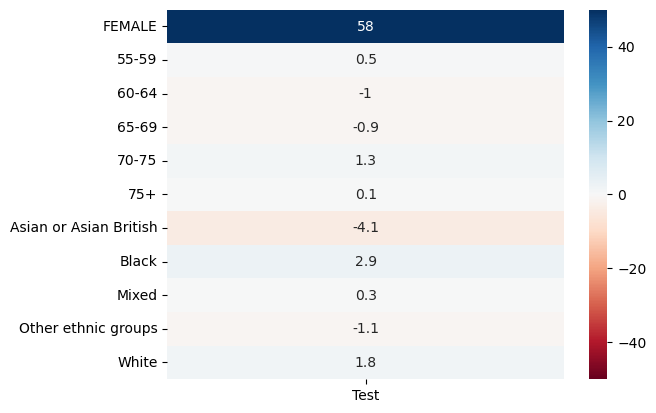

In [14]:
female_only = person_data[
    person_data['Available']&\
    (person_data['participant_details_gender'] == 'FEMALE')
]

datasets['training']['female_for_inference'] = empty_ds
datasets['validation']['female_for_inference'] = empty_ds
datasets['test']['female_for_inference'] = female_only.sample(frac=1, random_state=42)
datasets['holdout']['female_for_inference'] = empty_ds

combine_datasets_profiles('female_for_inference', datasets)


In [15]:
if REGENERATE:
    _ = save_metadata(datasets, 'female_for_inference', nodule_data)

    deploy_to_cluster('female_for_inference')

# White only - Gender investigations

Total white only scans: 4485
True True True False


,Training,Validation,Test,Total
FEMALE,1494 (44.4%),98 (43.8%),399 (44.4%),5504 (42.5%)
MALE,1869 (55.6%),126 (56.2%),499 (55.6%),7444 (57.5%)
55-59,625 (18.6%),43 (19.2%),178 (19.8%),2761 (21.3%)
60-64,794 (23.6%),49 (21.9%),219 (24.4%),3239 (25.0%)
65-69,869 (25.8%),68 (30.4%),208 (23.2%),3290 (25.4%)
70-75,881 (26.2%),54 (24.1%),240 (26.7%),2960 (22.9%)
75+,194 (5.8%),10 (4.5%),53 (5.9%),698 (5.4%)
White,3363 (100.0%),224 (100.0%),898 (100.0%),10794 (83.4%)
Total,3363,224,898,12948


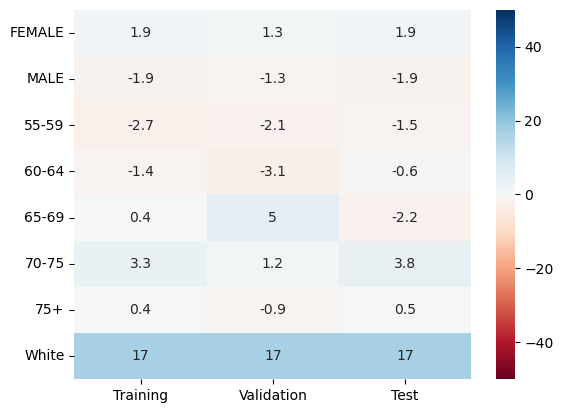

In [16]:


white_only = person_data[
    person_data['Available']&\
    (person_data['lung_health_check_demographics_race_ethnicgroup'] == 'White')
]

total = white_only.shape[0]

print(f'Total white only scans: {total}')

# Get the counts for each dataset
trn_cnt = int(total * 0.75)
val_cnt = int(total * 0.05)
tst_cnt = int(total * 0.20)

datasets['training']['white_only'] = white_only.loc[white_only.index[:trn_cnt],:]
datasets['validation']['white_only'] = white_only.loc[white_only.index[trn_cnt:trn_cnt+val_cnt],:]
datasets['test']['white_only'] = white_only.loc[white_only.index[trn_cnt+val_cnt:],:]
datasets['holdout']['white_only'] = empty_ds

test_ds = white_only.loc[white_only.index[trn_cnt+val_cnt:],:]
test_ds_male = test_ds[test_ds['participant_details_gender']=='MALE'].sample(399, random_state=42)
test_ds_female = test_ds[test_ds['participant_details_gender']=='FEMALE']

datasets['training']['balanced_white_only'] = empty_ds
datasets['validation']['balanced_white_only'] = empty_ds
datasets['test']['balanced_white_only'] = pd.concat([test_ds_male, test_ds_female]).sample(frac=1, random_state=42)
datasets['holdout']['balanced_white_only'] = empty_ds
combine_datasets_profiles('white_only', datasets)


In [17]:
if REGENERATE:
    _ = save_metadata(datasets, 'white_only', nodule_data)
    deploy_to_cluster('white_only')

False False True False


,Test,Total
FEMALE,399 (50.0%),5504 (42.5%)
MALE,399 (50.0%),7444 (57.5%)
55-59,157 (19.7%),2761 (21.3%)
60-64,198 (24.8%),3239 (25.0%)
65-69,179 (22.4%),3290 (25.4%)
70-75,212 (26.6%),2960 (22.9%)
75+,52 (6.5%),698 (5.4%)
White,798 (100.0%),10794 (83.4%)
Total,798,12948


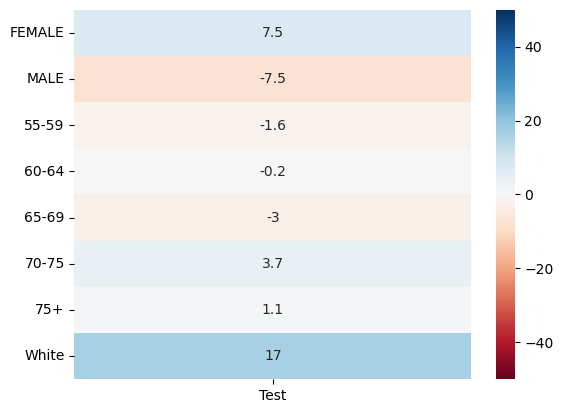

In [18]:
combine_datasets_profiles('balanced_white_only', datasets)
if REGENERATE:
    _ = save_metadata(datasets, 'balanced_white_only', nodule_data)
    deploy_to_cluster('balanced_white_only')


### Create a dataset for Asian or Asian British and Black participants for inference only

False False True False


,Test,Total
FEMALE,229 (20.4%),5504 (42.5%)
MALE,891 (79.6%),7444 (57.5%)
55-59,277 (24.7%),2761 (21.3%)
60-64,297 (26.5%),3239 (25.0%)
65-69,309 (27.6%),3290 (25.4%)
70-75,179 (16.0%),2960 (22.9%)
75+,58 (5.2%),698 (5.4%)
Asian or Asian British,666 (59.5%),844 (6.5%)
Black,454 (40.5%),577 (4.5%)
Total,1120,12948


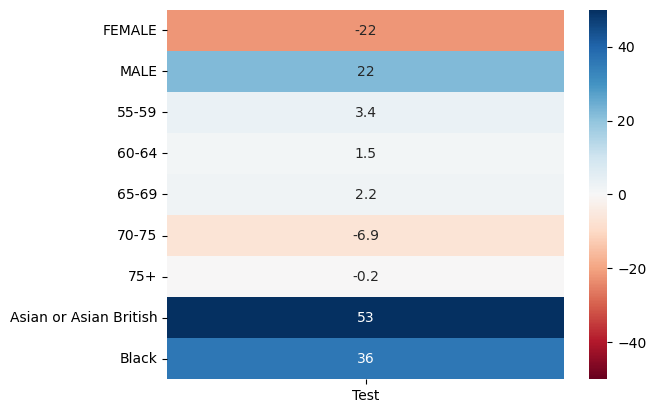

In [19]:
# Balanced the Test Dataset
asian_and_black = person_data[
    person_data['Available']&\
    (person_data['lung_health_check_demographics_race_ethnicgroup'].isin(['Asian or Asian British', 'Black']))
]

empty_ds = asian_and_black.drop(asian_and_black.index)

test_ds = asian_and_black

datasets['training']['non_white_for_inference'] = empty_ds
datasets['validation']['non_white_for_inference'] = empty_ds
datasets['test']['non_white_for_inference'] = test_ds
datasets['holdout']['non_white_for_inference'] = empty_ds

combine_datasets_profiles('non_white_for_inference', datasets)

if REGENERATE:
    _ = save_metadata(datasets, 'non_white_for_inference', nodule_data)

    deploy_to_cluster('non_white_for_inference')

# Optimisation of Nodule Detection Algorithms


Description: The follow up to teh Fairness paper, this explores how best to optimise nodule detection algorithms to better identify actionable nodules.

Additional SUMMIT scans are now available and as the focus has moved away from Fairness there is no need to maintain a balanced Test set wrt ethnic group.

Therefore a new selection for Training, Validation and Test will be carried out. As we plan to carry out FN/FP analysis and then optimise model/ training
regimes a test set and a hold out dataset will be required. We have 8385 lung scans available at the start of the project. The splits will therefore be:

- Hold out: 2000 (24%)
- Test: 1000 (12%)
- Training/ Validation: 5000 (60%)/385(~5%)



In [20]:
cached_scans = (
    pd.read_csv('/Users/john/Projects/ScansTransfer/src/lung_listings.txt', header=None, names=['mhd_path'])
    .assign(scan_id=lambda x: x.mhd_path.str.split('/').str[-1].str.replace('\.mhd', ''))
    .assign(study_id=lambda x: x.scan_id.str.split('_', n=1).str[0])
    .assign(timepoint=lambda x: x.scan_id.str.split('_',n=1).str[1])
    .query('timepoint == "Y0_BASELINE_A"')
)

person_data['Available'] = person_data['scan_id'].isin(cached_scans.scan_id)

# Filter available data
available_data = person_data[person_data.Available]

print(available_data.shape)

# Shuffle the data
available_data = available_data.sample(frac=1, random_state=42)

# Split the data
train_data = available_data.iloc[:5000]
test_data = available_data.iloc[5000:6000]
holdout_data = available_data.iloc[6000:8000]
validation_data = available_data.iloc[8000:]


print(train_data.shape, test_data.shape, holdout_data.shape, validation_data.shape)

# Assign to datasets dictionary
datasets['training']['optimisation'] = train_data
datasets['test']['optimisation'] = test_data
datasets['validation']['optimisation'] = validation_data
datasets['holdout']['optimisation'] = holdout_data


if REGENERATE:
    combine_datasets_profiles('optimisation', datasets)
    _ = save_metadata(datasets, 'optimisation', nodule_data)
    deploy_to_cluster('optimisation')

(8362, 319)
(5000, 319) (1000, 319) (2000, 319) (362, 319)


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_15523/1324906974.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  .assign(scan_id=lambda x: x.mhd_path.str.split('/').str[-1].str.replace('\.mhd', ''))


# Optimisation but actionable only


True True True True


,Training,Validation,Test,Holdout,Total
FEMALE,2006 (40.1%),131 (36.2%),407 (40.7%),821 (41.0%),5504 (42.5%)
MALE,2994 (59.9%),231 (63.8%),593 (59.3%),1179 (59.0%),7444 (57.5%)
55-59,1000 (20.0%),68 (18.8%),201 (20.1%),394 (19.7%),2761 (21.3%)
60-64,1238 (24.8%),108 (29.8%),243 (24.3%),464 (23.2%),3239 (25.0%)
65-69,1265 (25.3%),92 (25.4%),268 (26.8%),547 (27.4%),3290 (25.4%)
70-75,1211 (24.2%),78 (21.5%),231 (23.1%),493 (24.6%),2960 (22.9%)
75+,286 (5.7%),16 (4.4%),57 (5.7%),102 (5.1%),698 (5.4%)
Asian or Asian British,450 (9.0%),32 (8.8%),87 (8.7%),189 (9.4%),844 (6.5%)
Black,330 (6.6%),21 (5.8%),49 (4.9%),111 (5.5%),577 (4.5%)
Mixed,109 (2.2%),10 (2.8%),26 (2.6%),38 (1.9%),283 (2.2%)


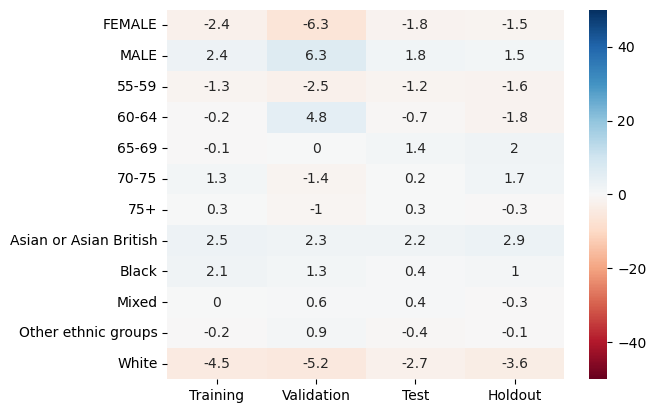

optimisation_actionable training scans metadata saved
optimisation_actionable training scans #: 5000
optimisation_actionable training metadata saved
optimisation_actionable training nodules: 2312 (Actionable: 2312)
optimisation_actionable training exclude metadata saved
optimisation_actionable training excluded nodules: 3893
optimisation_actionable validation scans metadata saved
optimisation_actionable validation scans #: 362
optimisation_actionable validation metadata saved
optimisation_actionable validation nodules: 143 (Actionable: 143)
optimisation_actionable validation exclude metadata saved
optimisation_actionable validation excluded nodules: 314
optimisation_actionable test scans metadata saved
optimisation_actionable test scans #: 1000
optimisation_actionable test metadata saved
optimisation_actionable test nodules: 469 (Actionable: 469)
optimisation_actionable test exclude metadata saved
optimisation_actionable test excluded nodules: 748
optimisation_actionable holdout scans 

In [24]:
datasets['training']['optimisation_actionable'] = datasets['training']['optimisation']
datasets['validation']['optimisation_actionable'] = datasets['validation']['optimisation']
datasets['holdout']['optimisation_actionable'] = datasets['holdout']['optimisation']
datasets['test']['optimisation_actionable'] = datasets['test']['optimisation']


combine_datasets_profiles(
    'optimisation_actionable',
    datasets
)

_ = save_metadata(
    datasets,
    'optimisation_actionable',
    nodule_data[nodule_data.management_plan.isin(['3_MONTH_FOLLOW_UP_SCAN','URGENT_REFERRAL', 'ALWAYS_SCAN_AT_YEAR_1'])],
    nodule_data[nodule_data.management_plan.isin(['RANDOMISATION_AT_YEAR_1'])]
)

deploy_to_cluster('optimisation_actionable')